# 7. Convex combination of normals
> Re-expressing Pagel's lambda with a convex combination of normals

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

from src.phylogenetic_signal import PagelsLambda

# Global variables
N_SAMP = 1000


# Numerical verification

In [2]:
# Intialize relevant objects
pl = PagelsLambda(tree="./seedplants/tree.nwk", format=0)

C = pl.C
N = pl.N

In [6]:
# Check for a random number
lam = np.random.rand() # Between 0 and 1

# Rescale the covariance matrix and sample from it
C_lam = pl.rescale_cov(lam, cov=C)

# Sample from this system
x = np.random.multivariate_normal(np.zeros(N), C_lam, size=N_SAMP)
lams = np.zeros(N_SAMP)
for i in range(N_SAMP):
    pl.fit(x[i, :].reshape(N, 1))
    lams[i] = pl.lam

print("Using rescaled covariance matrix:")
print("Mean:", np.mean(lams), "True:", lam)

Using rescaled covariance matrix:
Mean: 0.7435386265568266 True: 0.8001302184158308


In [8]:
# How does it look when we use a convex combination of the two covariance matrices?

C0 = pl.rescale_cov(0, cov=C)
C1 = pl.rescale_cov(1, cov=C)

C_lam_convex = lam * C1 + (1 - lam) * C0
assert np.allclose(C_lam, C_lam_convex)

C_sampled = np.cov(x.T)
print(np.sum(np.abs(C_lam - C_sampled)))

23.47365226047954


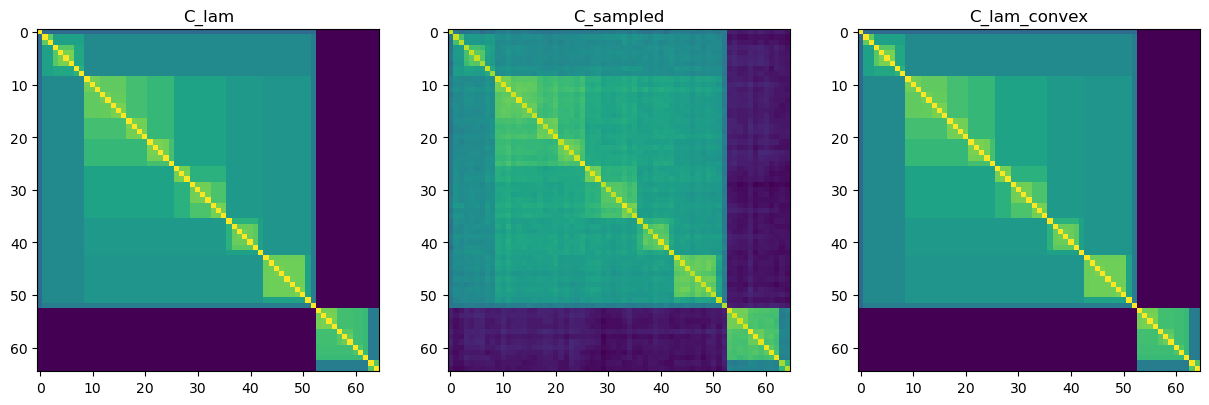

In [11]:
# Maybe plots will be more informatve:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, mat, name in zip(axs, [C_lam, C_sampled, C_lam_convex], ["C_lam", "C_sampled", "C_lam_convex"]):
    ax.imshow(mat)
    ax.set_title(name)

In [21]:
# Trying a search over lambdas

def loglikelihood(lam, x):
    C_lam = pl.rescale_cov(lam, cov=C)
    z0, sigma2, ll = pl.mle(x, C_lam, unbiased=True)
    return ll

lams_convex = np.zeros(N_SAMP)
for i in trange(N_SAMP):
    max_ll = -np.inf
    best_lam = None
    for candidate_lam in np.linspace(0, 1, 100):
        ll = loglikelihood(lam, x[i, :].reshape(N, 1))
        if ll > max_ll:
            max_ll = ll
            best_lam = lam
    lams_convex[i] = best_lam

print("Using convex combination of covariance matrices:")
print("Mean:", np.mean(lams_convex), "True:", lam) 

# Actually .80, I clobbered the true value
# But more importantly, the MLE is the same!

100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]

Using convex combination of covariance matrices:
Mean: 0.7434444444444446 True: 1.0


# Developing an MLE framework

## Part 1: Determining means, variances, etc.

In [39]:
# What is z0 as a function of lambda?

# Get our component covariance matrices
C_0 = pl.rescale_cov(0, cov=C)
C_1 = pl.rescale_cov(1, cov=C)

# Get a random lambda
lam_true = np.random.rand()
z0_true = np.random.rand()
C_lam = pl.rescale_cov(lam_true, cov=C)

# Sample
x = np.random.multivariate_normal(z0_true * np.ones(N), C_lam, size=1).T

# Get MLE means and variances
z0_0, sigma2_0, ll_0 = pl.mle(x, C_0, unbiased=True)
z0_1, sigma2_1, ll_1 = pl.mle(x, C_1, unbiased=True)

# Assert that we know what these are:
assert np.allclose(z0_0, np.mean(x))

# For some random lambda, represent z0_MLE in terms of z0_0 and z0_1:
z0_mle, _, _ = pl.mle(x, C_lam, unbiased=True)
z0_convex = lam_true * z0_1 + (1 - lam_true) * z0_0

print(
    f"z0 (true):\t{z0_true:.3f}",
    f"z0 (MLE):\t{z0_mle:.3f}",
    f"z0 (convex):\t{z0_convex:.3f}",
    sep="\n"
)

# # Represent z0_random as a convex combination of z0_0 and z0_1
# z0_convex = random_lam * z0_1 + (1 - random_lam) * z0_0
# print("Convex combination:", z0_convex)

z0 (true):	0.870
z0 (MLE):	0.844
z0 (convex):	0.887


 So this is not quite right. I appear to be off by some small factor, whereas I
 want the MLE and convex to be exactly the same all the time. I will come back
 to this later.